# Exercise 1

This Excercise has the goal to determine the share of valid/invalid/not-found BGP annoucnements based on a data dump from the Oregon collector on April 14th 2020. The result will be similar to https://rpki-monitor.antd.nist.gov/

The command used to generate the BGP dump: 
nohup bgpreader -w 1586822400,1586851200 -c route-views2 -t ribs > bgpdata_exercise_1.txt &


The ROAs to validate each BGP announcement were collected from http://valid.rg.net:8080/ for the same date at 12am UTC. You can export the dataset here: http://valid.rg.net:8080/api/export.json

DISCLAIMER: This is an exercise and it is simplifying many things, it is not correctly implementing RFC 6811!




The following code snippet imports all dependencies

In [1]:
from ipaddress import ip_network
import pybgpstream
import bgpReader_util.bgp as bgp
import json
import matplotlib.pyplot as plt

Now we read all ROAs from the prefetched JSON file. The datastructure looks as follows: http://localhost:8888/edit/Exercise_1/roa_export_20200415.json

To simplify lookups, we build a dictionary that uses the prefixes as keys. The values are the ROAs existing for the respective prefix. The datastructure looks as follows:

{
'58.181.75.0/24': [{'asn': '0', 'prefix': '58.181.75.0/24', 'maxLength': 24, 'ta': 'APNIC RPKI Root'}],
'101.97.43.0/24': [{'asn': '0', 'prefix': '101.97.43.0/24', 'maxLength': 24, 'ta': 'APNIC RPKI Root'}, {'asn': '1', 'prefix': '58.181.0.0/16', 'maxLength': 24, 'ta': 'APNIC RPKI Root'}]
}

In [2]:
roas = {}
with open("Exercise_1/roa_export_20200415.json", "r") as read_file:
    roa_data = json.load(read_file)
    for roa in roa_data['roas']:
        if roa['prefix'] not in roas:
            roas[roa['prefix']] = []
        roas[roa['prefix']].append(roa)

Initialize result variables for valid/invalid/not-found.

In [3]:
valid = set()
invalid = set()
not_found = set()

Next, let´s read our bgp dump and implement the exercise.

In [4]:
with open('Exercise_1/short.txt', 'r') as f_in: # This is a random sample of 1k lines
    for line in f_in:
        if not bgp.is_relevant_line(line, ['\n', '/', '#']): #Filter non BGP-Elements
            continue
        bgp_fields = bgp.get_bgp_fields(line, 'v2') #Parse BGP fields
        if not bgp.is_valid_bgp_entry(bgp_fields): #Filter corrupted BGP-Elements
            continue
            
        origin = bgp_fields['origin']        #E.g. '47065'
        prefix = bgp_fields['prefix']        #E.g. '147.28.240.0/24'
        identifier = prefix + " + " + origin #E.g. '147.28.240.0/24 + 47065'
        
        if identifier in (not_found | valid | invalid): continue #Only perform lookup once (unique prefix/origin pairs)
        
        
        not_found.add(identifier) #If we can find a ROA that renders this prefix valid/invalid, it is not_found
        
        bgpdump_prefix = ip_network(prefix)
        if bgpdump_prefix.version != 4: continue # Only check IPv4 address space
        

        if prefix in roas: #Match found in ROAs for this prefix
            
            pass #remove pass
            #
            # ADD YOUR CODE HERE
            #


Let´s see how many prefixes we validated:

In [5]:
print('Items in VALID: ', len(valid))
print('Items in INVALID: ', len(invalid))
print('Items in NOT FOUND: ', len(not_found))

Items in VALID:  0
Items in INVALID:  0
Items in NOT FOUND:  1000


In [6]:
share_valid = round((100 / (len(valid) + len(invalid) + len(not_found))) * len(valid), 2)
share_invalid = round((100 / (len(valid) + len(invalid) + len(not_found))) * len(invalid), 2)
share_notfound = round((100 / (len(valid) + len(invalid) + len(not_found))) * len(not_found), 2)

print('Prefixes VALID [%]: ', share_valid)
print('Prefixes INVALID [%]: ', share_invalid)
print('Prefixes NOT FOUND [%]: ', share_notfound)

Prefixes VALID [%]:  0.0
Prefixes INVALID [%]:  0.0
Prefixes NOT FOUND [%]:  100.0


This code snippet generates a pie chart for you.

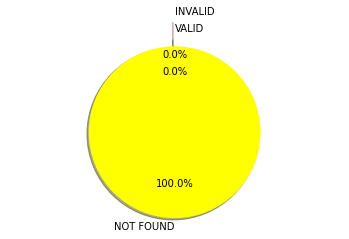

In [7]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'VALID', 'NOT FOUND', 'INVALID'
sizes = [share_valid, share_notfound, share_invalid]
explode = (0, 0.1, 0.2)
colors = ['green', 'yellow', 'red']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()